In [1]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
import seaborn as sns

## Data Loading

Buat struktur folder dataset sebagai berikut:
```
.
└──dataset
    ├── label1
	├── image1.jpg
	├── image2.jpg
	└── image3.jpg
    ├── label2
    └── label3
    └── dst...
```

In [2]:
data = []
labels = []
file_name = []
for sub_folder in os.listdir("dataset\\"):
    sub_folder_files = os.listdir(os.path.join("dataset\\", sub_folder))
    for i, filename in enumerate(sub_folder_files):
        img_path = os.path.join("dataset\\", sub_folder, filename)
        img = cv.imread(img_path)
        img = img.astype(np.uint8)
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        
        data.append(img)
        labels.append(sub_folder)
        name = os.path.splitext(filename)[0]
        file_name.append(filename)
        
data = np.array(data)
labels = np.array(labels)


## Data Augmentation

### Define Augmentation Function


In [3]:
# melakukan augmentasi data
data_augmented = []
labels_augmented = []
paths_augmented = []
file_name_augmented = []
for i in range(len(data)):
	pass

In [4]:
print("Data sebelum augmentasi: ", len(data))
print("Data setelah augmentasi: ", len(data_augmented))

Data sebelum augmentasi:  400
Data setelah augmentasi:  0


## Data Preparation

### Define Preprocessing Function


In [5]:
def resize(img, th, tw):
    h, w = img.shape
    resized = np.zeros((th, tw), dtype=np.uint8)
    
    skala_y = h / th
    skala_x = w / tw
    
    for i in range(th):
        for j in range(tw):
            src_y = int(i * skala_y)
            src_x = int(j * skala_x)
            resized[i, j] = img[src_y, src_x]
    
    return resized

def normalisasi(img):
    min_val = np.min(img)
    max_val = np.max(img)
    if max_val - min_val == 0:
        return np.zeros_like(img, dtype=np.uint8)
    normalized_img = ((img - min_val) / (max_val - min_val)) * 255
    return normalized_img.astype(np.uint8)

def ekualisasi(img):
    hist = np.zeros(256, dtype=int)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            hist[img[i, j]] += 1

    total_pixels = img.shape[0] * img.shape[1]
    pdf = hist / total_pixels

    cdf = np.zeros(256)
    cdf[0] = pdf[0]
    for i in range(1, 256):
        cdf[i] = cdf[i - 1] + pdf[i]

    cdf_normalized = np.round(cdf * 255).astype(np.uint8)

    ekualisasi_img = np.zeros_like(img)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            ekualisasi_img[i, j] = cdf_normalized[img[i, j]]

    return ekualisasi_img


                    

### Preprocessing

In [6]:
dataPreprocessed = []
for i in range(len(data)): 
	img = data[i]
	img = resize(img, 128, 128)
	img = normalisasi(img)
	img = ekualisasi(img)
	dataPreprocessed.append(img)

	

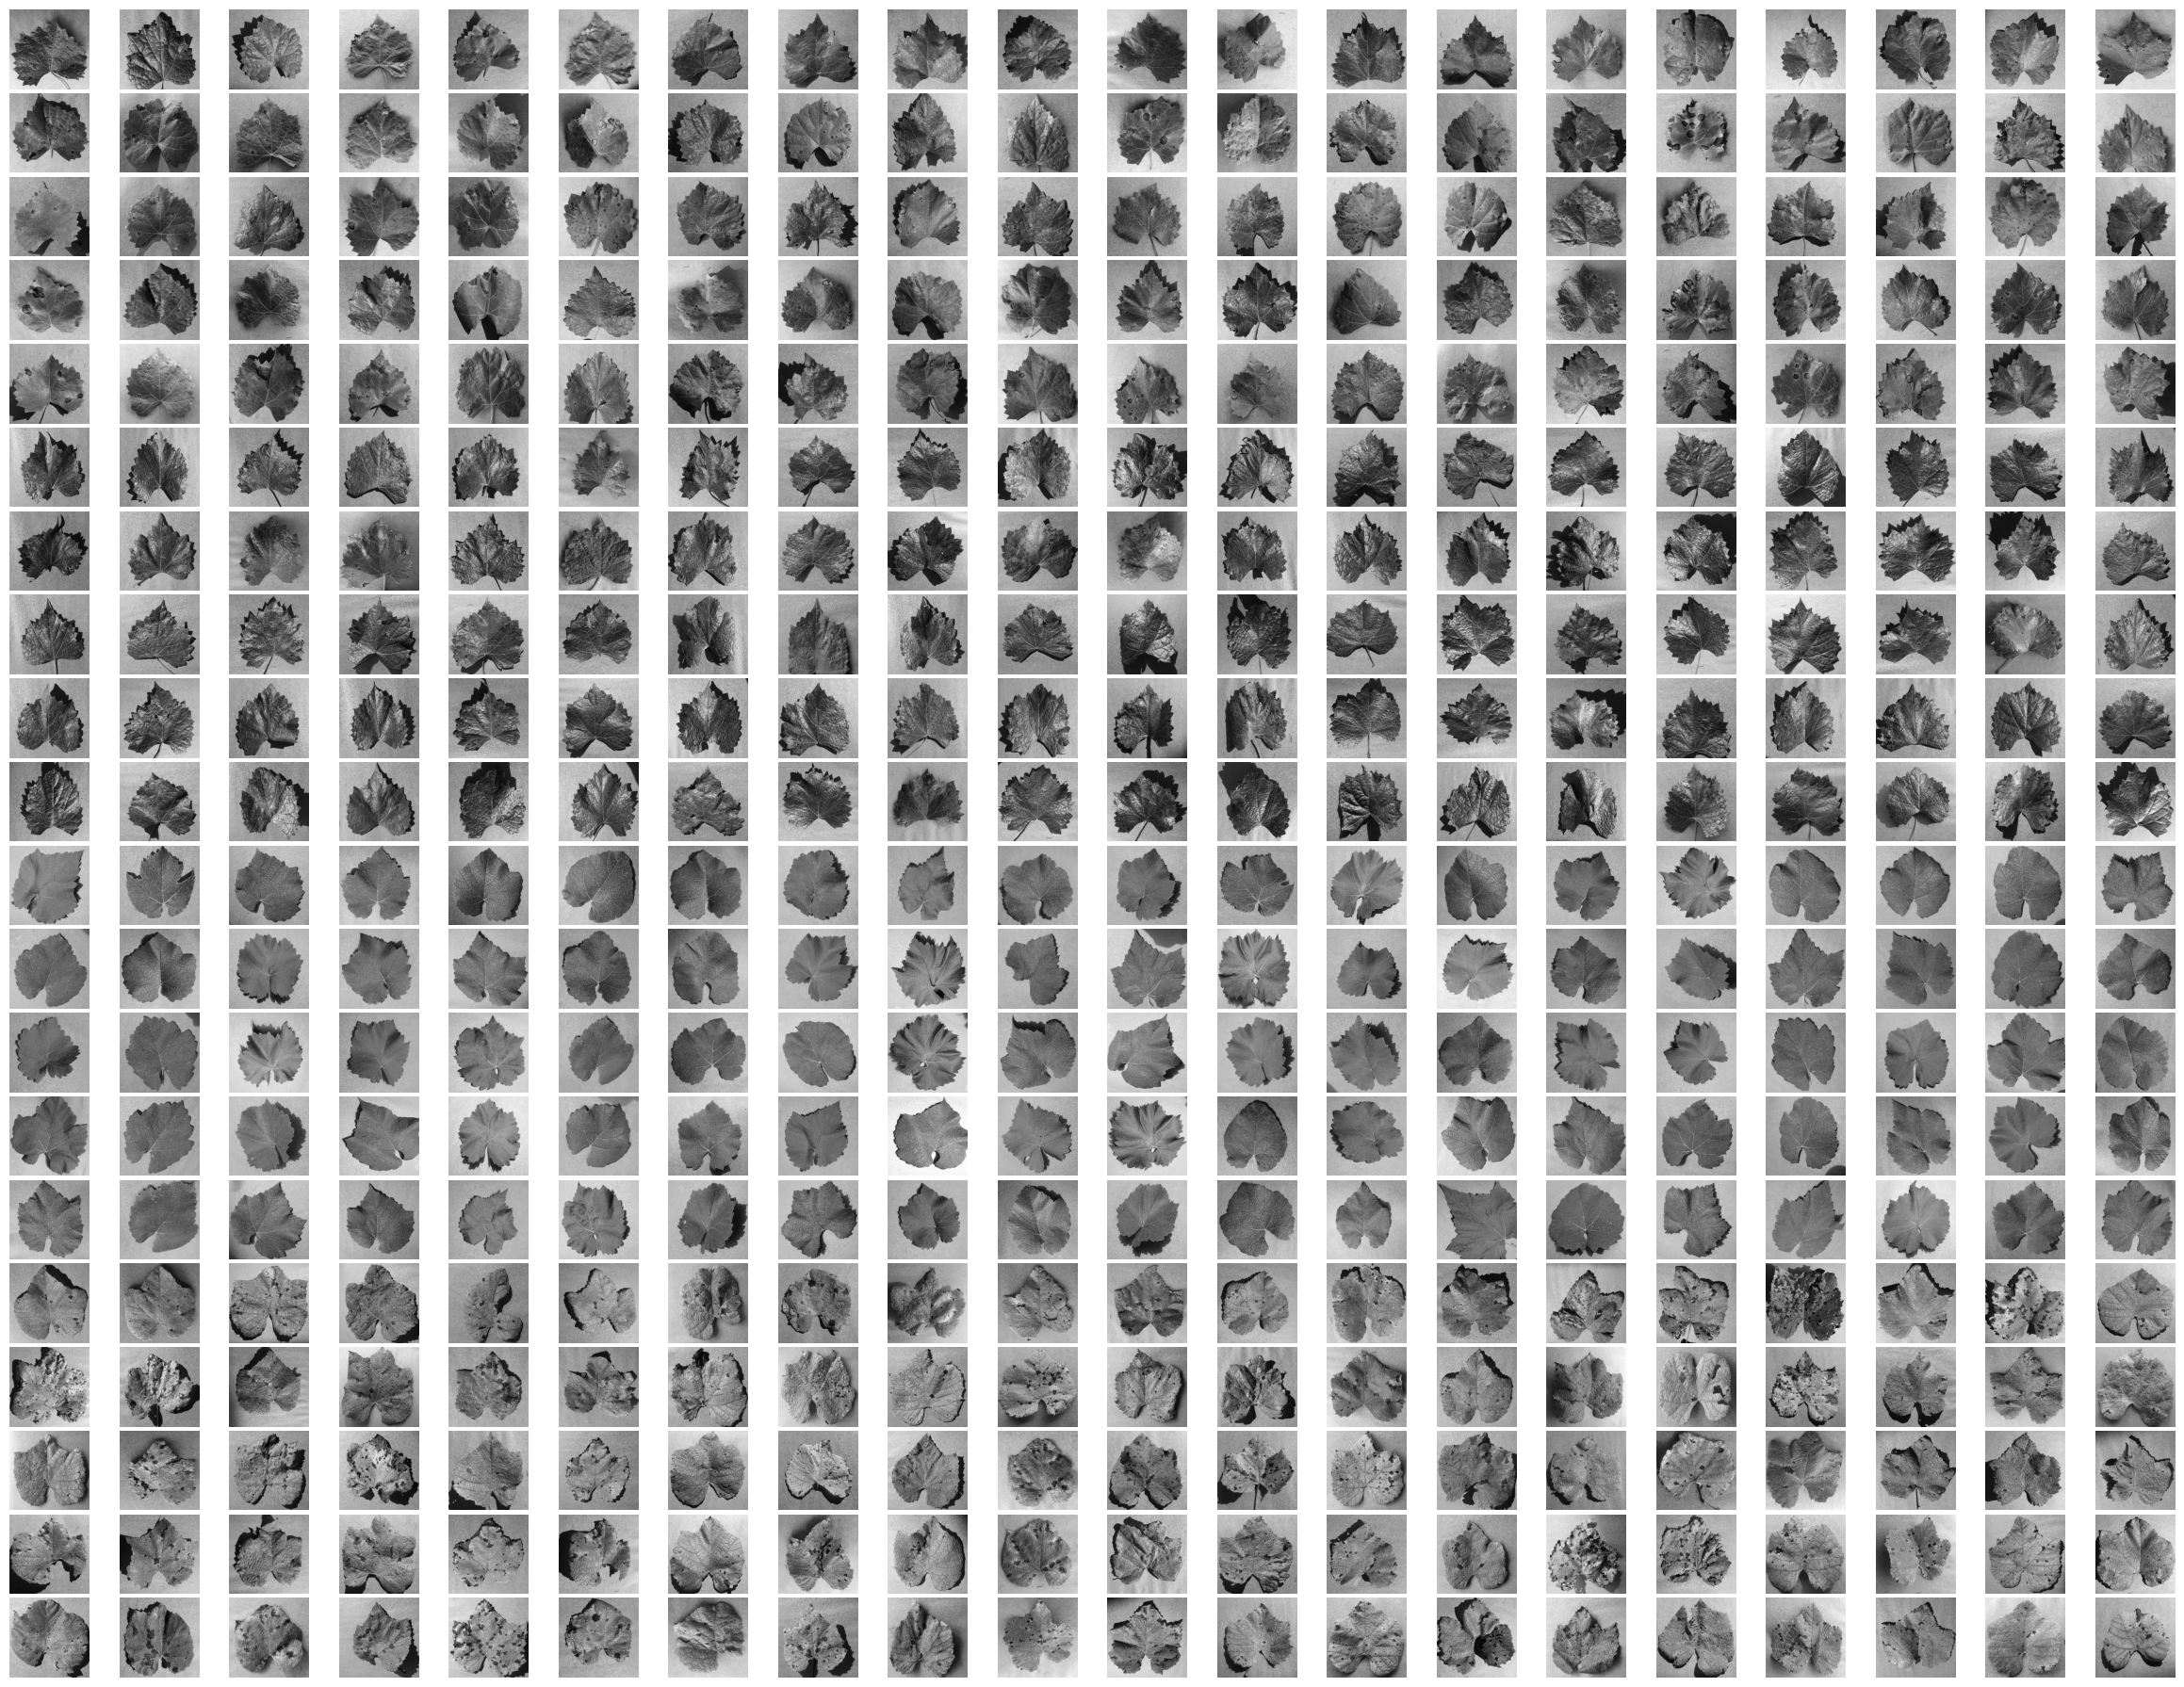

In [7]:
max_display = 400
display_data = data[:max_display]

columns = 20
total = len(display_data)
rows = -(-total // columns)

fig, axes = plt.subplots(nrows=rows, ncols=columns, figsize=(30, 23))

axes_list = axes.ravel() if total > 1 else [axes]

for idx in range(rows * columns):
    ax = axes_list[idx]
    if idx < total:
        ax.imshow(display_data[idx], cmap='gray')
    ax.axis('off')

plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()

### Feature Extraction

In [8]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    
    # mengembalikan matrix glcm dari image
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    return glcm

In [9]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

In [10]:
def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

In [11]:
def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

In [12]:
def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

In [13]:
def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

In [14]:
def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

In [15]:
def entropyGlcm(matriks):
    return entropy(matriks.ravel())

In [16]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(dataPreprocessed)):
    D0 = glcm(dataPreprocessed[i], 0)
    D45 = glcm(dataPreprocessed[i], 45)
    D90 = glcm(dataPreprocessed[i], 90)
    D135 = glcm(dataPreprocessed[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

In [17]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []


In [18]:
for i in range(len(dataPreprocessed)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

In [19]:
for i in range(len(dataPreprocessed)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

In [20]:
for i in range(len(dataPreprocessed)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

In [21]:
for i in range(len(dataPreprocessed)):
    H0 = homogenity(Derajat0[i])
    H45 = homogenity(Derajat45[i])
    H90 = homogenity(Derajat90[i])
    H135 = homogenity(Derajat135[i])
    homogenity0.append(H0)
    homogenity45.append(H45)
    homogenity90.append(H90)
    homogenity135.append(H135)

In [22]:
for i in range(len(dataPreprocessed)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

In [23]:
for i in range(len(dataPreprocessed)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

In [24]:
for i in range(len(dataPreprocessed)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

In [25]:
print("Filename:", len(file_name))
print("Label:", len(labels))
print("Kontras0:", len(Kontras0))
print("Kontras45:", len(Kontras45))
print("Kontras90:", len(Kontras90))
print("Kontras135:", len(Kontras135))
print("Homogeneity0:", len(homogenity0))
print("Homogeneity45:", len(homogenity45))
print("Homogeneity90:", len(homogenity90))
print("Homogeneity135:", len(homogenity135))
print("Entropy0:", len(entropy0))
print("Entropy45:", len(entropy45))
print("Entropy90:", len(entropy90))
print("Entropy135:", len(entropy135))
print("Correlation0:", len(correlation0))
print("Correlation45:", len(correlation45))
print("Correlation90:", len(correlation90))
print("Correlation135:", len(correlation135))


Filename: 400
Label: 400
Kontras0: 400
Kontras45: 400
Kontras90: 400
Kontras135: 400
Homogeneity0: 400
Homogeneity45: 400
Homogeneity90: 400
Homogeneity135: 400
Entropy0: 400
Entropy45: 400
Entropy90: 400
Entropy135: 400
Correlation0: 400
Correlation45: 400
Correlation90: 400
Correlation135: 400


### Write the extraction's results to CSV 

In [26]:
dataTable = {'Filename': file_name, 'Label': labels,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_1.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_1.csv')
hasilEkstrak


Filename  \
0    003d09ef-e16c-4e8a-badf-847d46cb3dc0___FAM_B.R...   
1    00cab05d-e87b-4cf6-87d8-284f3ec99626___FAM_B.R...   
2    00cff577-afd4-4e36-ac9c-a52aa6ae5949___FAM_B.R...   
3    02c0e019-97c2-48f5-ac40-90b8789e6288___FAM_B.R...   
4    02f75392-dbad-4ab8-a35d-d391f9d57113___FAM_B.R...   
..                                                 ...   
395  4cd25f42-7cda-4507-a1bd-a03b5f439ef5___FAM_L.B...   
396  4d7ad495-1420-4ac7-9123-f0aa1e828270___FAM_L.B...   
397  4d8aa281-ddb5-4f46-a95c-72a65c59903a___FAM_L.B...   
398  4e32244f-8e20-4788-8c49-93e971113104___FAM_L.B...   
399  4f1d732d-fe6b-423e-9ec5-c901b63e204e___FAM_L.B...   

                                          Label    Contrast0   Contrast45  \
0                             Grape___Black_rot  1425.603900  1764.686155   
1                             Grape___Black_rot  1972.958661  2107.311303   
2                             Grape___Black_rot  2362.146161  2647.006262   
3                             Grape___Black_rot   939.646900  1247.236654   
4                             Grape___Black_rot  1672.310101  1881.946184   
..                                          ...          ...          ...   
395  Grape___Leaf_blight_(Isariopsis_Leaf_Spot)  2531.442790  2709.681877   
396  Grape___Leaf_blight_(Isariopsis_Leaf_Spot)  1887.087291  1807.434311   
397  Grape___Leaf_blight_(Isariopsis_Leaf_Spot)  3015.960999  3147.707111   
398  Grape___Leaf_blight_(Isariopsis_Leaf_Spot)  1704.539801  1937.043648   
399  Grape___Leaf_blight_(Isariopsis_Leaf_Spot)  1799.914616  1989.410999   

      Contrast90  Contrast135  Homogeneity0  Homogeneity45  Homogeneity90  \
0    1760.101378  2011.771034      0.071980       0.067142       0.069129   
1    1871.987820  2542.735259      0.051514       0.050239       0.051089   
2    2311.426181  2735.360779      0.059377       0.055036       0.058783   
3    1191.043861  1291.423523      0.060252       0.053418       0.055839   
4    1697.425874  1803.661479      0.056580       0.052339       0.057816   
..           ...          ...           ...            ...            ...   
395  2349.012488  2771.151838      0.058348       0.053121       0.059381   
396  1651.813546  2040.350115      0.073702       0.065696       0.071799   
397  2996.103223  3371.385641      0.054824       0.051341       0.057551   
398  1768.526575  1781.687519      0.060977       0.053241       0.060650   
399  1769.056348  2013.609027      0.073595       0.069644       0.074438   

     Homogeneity135  ...     ASM90    ASM135   Energy0  Energy45  Energy90  \
0          0.064069  ...  0.000164  0.000156  0.013152  0.012773  0.012815   
1          0.043708  ...  0.000112  0.000101  0.010464  0.010530  0.010588   
2          0.053206  ...  0.000141  0.000131  0.011829  0.011595  0.011881   
3          0.052996  ...  0.000183  0.000183  0.014254  0.013508  0.013533   
4          0.058322  ...  0.000151  0.000151  0.012491  0.012115  0.012306   
..              ...  ...       ...       ...       ...       ...       ...   
395        0.052269  ...  0.000149  0.000139  0.012144  0.011904  0.012188   
396        0.062961  ...  0.000190  0.000170  0.013654  0.013464  0.013800   
397        0.046649  ...  0.000199  0.000184  0.014010  0.013866  0.014120   
398        0.058346  ...  0.000188  0.000186  0.013851  0.013335  0.013728   
399        0.066248  ...  0.000220  0.000201  0.014675  0.014395  0.014838   

     Energy135  Correlation0  Correlation45  Correlation90  Correlation135  
0     0.012472      0.867831       0.835995       0.836772        0.813035  
1     0.010034      0.817858       0.805265       0.827408        0.765047  
2     0.011455      0.782186       0.756246       0.787369        0.748124  
3     0.013511      0.913694       0.885388       0.890459        0.881324  
4     0.012280      0.846715       0.827777       0.844534        0.834934  
..         ...           ...            ...            ...             ...  
395   0.011771      0.7

### Features Selection

pada bagian seleksi fitur ini bisa menggunakan metode seperti
- PCA
- LDA
- t-SNE
- Chi-square
- ANOVA
- Autoencoder
- correlation
- dll

berikut contoh menggunakan correlation:

<Axes: >

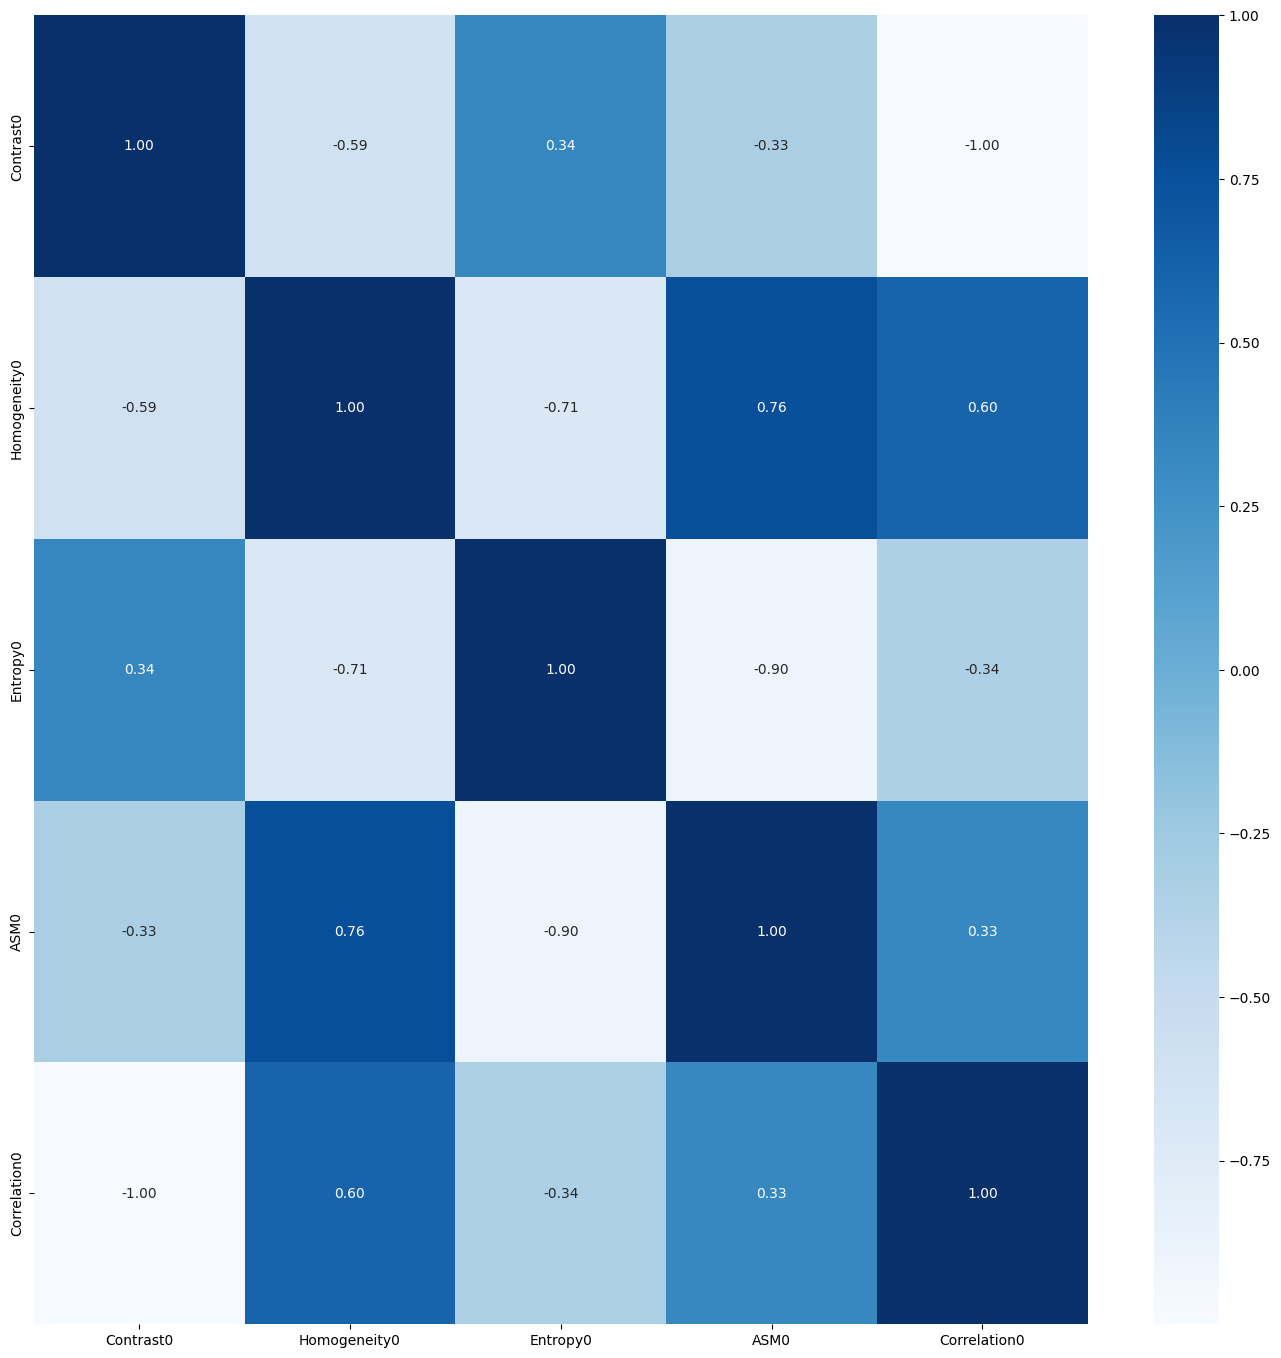

In [27]:
# Menghitung korelasi
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

# Menyaring fitur yang memiliki korelasi absolut lebih dari 0.95 dengan label
threshold = 0.95 # atur threshold ini untuk menentukan seberapa besar korelasi yang ingin disaring
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))
sns.heatmap(x_new.corr(), annot=True, cmap='Blues', fmt=".2f")

## Splitting Data

In [28]:
# ubah bagian test_size sesuai kebutuhan
# 0.3 = 30% data untuk testing (train/test 70/30)
# 0.2 = 20% data untuk testing (train/test 80/20)
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(320, 5)
(80, 5)


## Feature Normalization

berikut metode normalisasi yang bisa digunakan:
- Min-Max Scaling
- Standardization (Z-score)
- Robust Scaling
- MaxAbsScaler
- dll

berikut contoh menggunakan Standardization (Z-score):

In [29]:
# normalisasi mean std
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

## Modeling

### Define Model

In [30]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

### Train Random Forest Classifier

In [31]:
# Train Random Forest Classifier
rf.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------Training Set------
                                            precision    recall  f1-score   support

                         Grape___Black_rot       0.92      0.99      0.95        74
              Grape___Esca_(Black_Measles)       0.89      0.98      0.93        82
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)       0.95      0.90      0.93        82
                           Grape___healthy       1.00      0.89      0.94        82

                                  accuracy                           0.94       320
                                 macro avg       0.94      0.94      0.94       320
                              weighted avg       0.94      0.94      0.94       320

[[73  1  0  0]
 [ 1 80  1  0]
 [ 3  5 74  0]
 [ 2  4  3 73]]
Accuracy: 0.9375

------Testing Set------
                                            precision    recall  f1-score   support

                         Grape___Black_rot       0.64      0.54      0.58        26
              Grape___Esca_(

### Train SVM Classifier

In [32]:
# Train SVM Classifier
svm.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
                                            precision    recall  f1-score   support

                         Grape___Black_rot       0.63      0.65      0.64        74
              Grape___Esca_(Black_Measles)       0.62      0.67      0.65        82
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)       0.71      0.76      0.73        82
                           Grape___healthy       0.91      0.77      0.83        82

                                  accuracy                           0.71       320
                                 macro avg       0.72      0.71      0.71       320
                              weighted avg       0.72      0.71      0.72       320

[[48 17  8  1]
 [15 55 11  1]
 [ 8  8 62  4]
 [ 5  8  6 63]]
Accuracy: 0.7125

------Testing Set------
                                            precision    recall  f1-score   support

                         Grape___Black_rot       0.81      0.81      0.81        26
              Grape___Esca_

### Train KNN Classifier

In [33]:
# Train KNN Classifier
knn.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)



------Training Set------
                                            precision    recall  f1-score   support

                         Grape___Black_rot       0.60      0.68      0.64        74
              Grape___Esca_(Black_Measles)       0.63      0.72      0.67        82
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)       0.79      0.76      0.78        82
                           Grape___healthy       0.95      0.76      0.84        82

                                  accuracy                           0.73       320
                                 macro avg       0.74      0.73      0.73       320
                              weighted avg       0.75      0.73      0.73       320

[[50 18  6  0]
 [19 59  2  2]
 [11  8 62  1]
 [ 3  9  8 62]]
Accuracy: 0.728125

------Testing Set------
                                            precision    recall  f1-score   support

                         Grape___Black_rot       0.73      0.92      0.81        26
              Grape___Esc

## Evaluation With Confusion Matrix

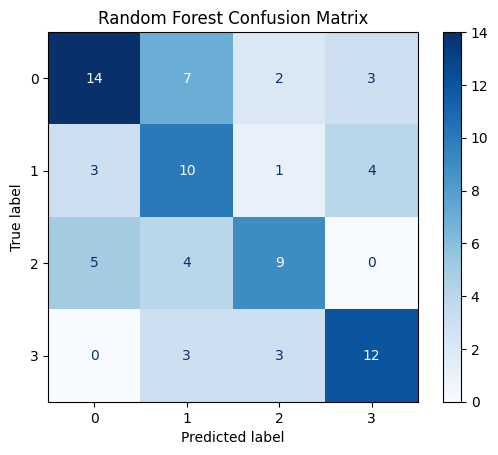

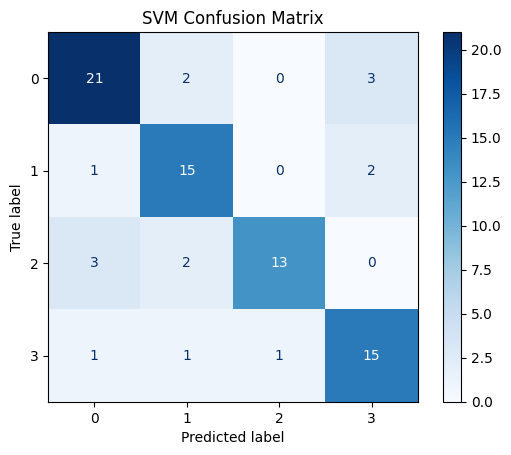

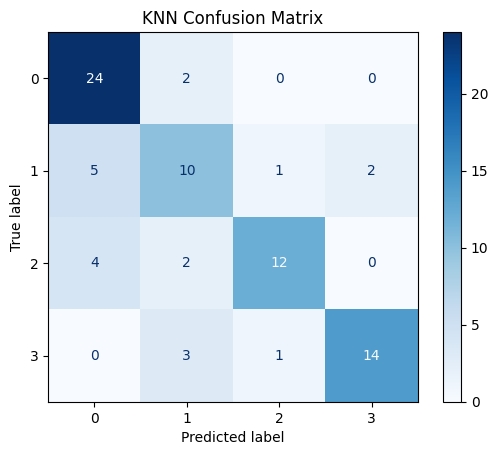

In [34]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")